In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [28]:
data = pd.read_csv('C:/Users/Hp/Desktop/Datasets/House Price Prediction Dataset.csv')

In [53]:
data.head()

,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location,Condition,Garage,Price
0,1,1360,5,4,3,1970,Downtown,Excellent,No,149919
1,2,4272,5,4,3,1958,Downtown,Excellent,No,424998
2,3,3592,2,2,3,1938,Downtown,Good,No,266746
3,4,966,4,2,2,1902,Suburban,Fair,Yes,244020
4,5,4926,1,4,2,1975,Downtown,Fair,Yes,636056


In [30]:
data.tail()

,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location,Condition,Garage,Price
1995,1996,4994,5,4,3,1923,Suburban,Poor,No,295620
1996,1997,3046,5,2,1,2019,Suburban,Poor,Yes,580929
1997,1998,1062,5,1,2,1903,Rural,Poor,No,476925
1998,1999,4062,3,1,2,1936,Urban,Excellent,Yes,161119
1999,2000,2989,5,1,3,1903,Suburban,Fair,No,482525


In [ ]:
print("Dataset shape:", data.shape)
print("\nData types:")
print(data.dtypes)
print("\nMissing values:")
print(data.isnull().sum())

Dataset shape: (2000, 10)

Data types:
Id            int64
Area          int64
Bedrooms      int64
Bathrooms     int64
Floors        int64
YearBuilt     int64
Location     object
Condition    object
Garage       object
Price         int64
dtype: object

Missing values:
Id           0
Area         0
Bedrooms     0
Bathrooms    0
Floors       0
YearBuilt    0
Location     0
Condition    0
Garage       0
Price        0
dtype: int64


In [ ]:
def preprocess_features(data):
    
    df = data.copy()
    
    df['PricePerSqFt'] = df['Price'] / df['Area']
    
    df['RoomRatio'] = df['Bedrooms'] / (df['Bathrooms'] + 1e-10)  # Avoid division by zero
    
    current_year = 2024
    df['HouseAge'] = current_year - df['YearBuilt']
    
    df['TotalRooms'] = df['Bedrooms'] + df['Bathrooms']
    
    location_counts = df['Location'].value_counts()
    top_locations = location_counts[location_counts > 100].index.tolist()
    df['Location'] = df['Location'].apply(
        lambda x: x if x in top_locations else 'Other')
    
    condition_order = {'Poor' : 1, 'Fair' : 2, 'Good': 3, 'Excellent' : 4 }
    df['Condition_Score'] = df['Condition'].map(condition_order).fillna(2)

    #df['Has_Garage'] = df['Garage'].map({'Yes' : 1, 'No' : 0 }).filna(0)

    numerical_cols = ['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt']
    
    for col in numerical_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = np.clip(df[col], lower_bound, upper_bound)
    
    return df

processed_data = preprocess_features(data)
print("Processed Data Shape:",processed_data.shape)



Processed Data Shape: (2000, 15)


Available features for modeling: ['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'HouseAge', 'TotalRooms', 'Condition_Score', 'Location']


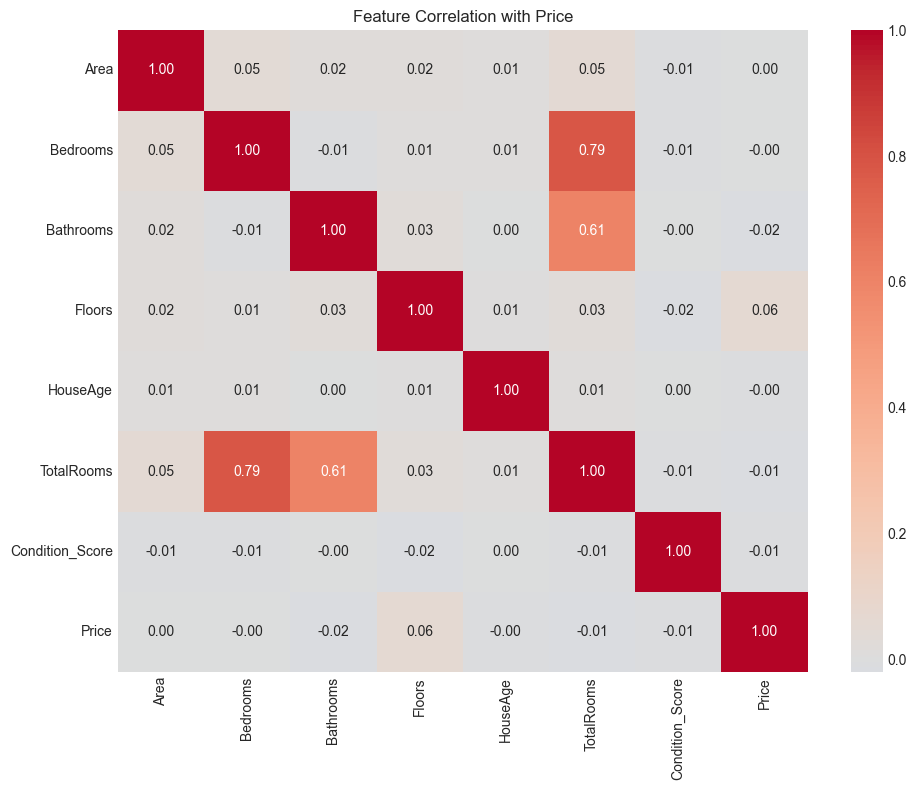

In [ ]:
# Define features and target
feature_cols = [
    'Area',           # Square footage
    'Bedrooms',       # Number of bedrooms
    'Bathrooms',      # Number of bathrooms
    'Floors',         # Number of floors
    'HouseAge',       # Age of house
    'TotalRooms',     # Total rooms
    'Condition_Score', # Condition score
    'Location'        # Location (categorical)
]

available_features = [col for col in feature_cols if col in processed_data.columns]
print("Available features for modeling:", available_features)

X = processed_data[available_features]
y = processed_data['Price']

numeric_features = X.select_dtypes(include=[np.number]).columns
correlation_matrix = processed_data[numeric_features.tolist() + ['Price']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation with Price')
plt.tight_layout()
plt.show()

In [71]:
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"Training set : {x_train.shape[0]} sample")
print(f"Testing set : {x_test.shape[0]} sample")
print(f"Feature : {x_train.shape[1]} sample")

Training set : 1340 sample
Testing set : 660 sample
Feature : 8 sample


In [78]:
numerical_cols = x_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = x_train.select_dtypes(include=['object']).columns.to_list()
print(f"Numarical Feature : {numeric_features}")
print(f"Categorical Feature : {categorical_cols}")

preprocess = ColumnTransformer(
    transformers = [
        ('num',StandardScaler(),numerical_cols),
        ('cat',OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore'),categorical_cols)
    ]
)

Numarical Feature : Index(['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'HouseAge', 'TotalRooms',
       'Condition_Score'],
      dtype='object')
Categorical Feature : ['Location']


In [ ]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor',preprocess),
    ('Regressor', LinearRegression())
])

lr_pipeline.fit(x_train,y_train)



,steps,"[('preprocessor', ...), ('Regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [82]:
y_pred_lr =lr_pipeline.predict(x_test)